In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss 
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
from numpy.linalg import norm

In [3]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])

In [4]:
np.random.seed(0)

# **Generate Data**

In [5]:
iris = load_iris()
data = iris.data[:,:2]
labels = iris.target

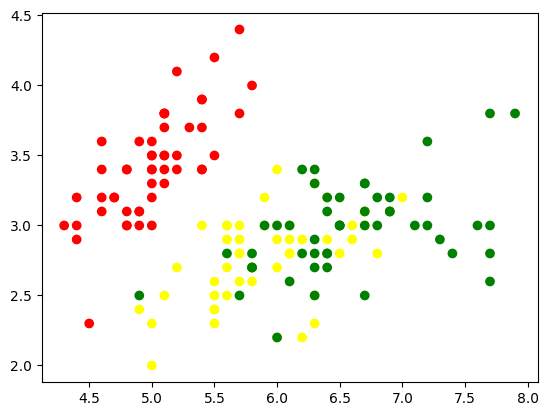

In [6]:
plt.scatter(data[:,0], data[:,1], c = labels, cmap = cmap)
plt.show()

In [7]:
print(data.shape, labels.shape)

(150, 2) (150,)


# **MultiClass Classification**

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify = labels, test_size = 0.2, random_state = 0) 

In [16]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(120, 2) (30, 2) (120,) (30,)


In [21]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
Y_OH_test = enc.fit_transform(np.expand_dims(Y_test,1)).toarray()
print(Y_OH_train.shape, Y_OH_test.shape)

(120, 3) (30, 3)


# **FF Class**

In [62]:
class FFNetwork():
    def __init__(self, num_hidden = 2, init_method = 'xavier', activation_function = 'sigmoid', leaky_slope = 0.1):
        self.params = {}
        self.num_layers = 2
        self.layer_size = [2, num_hidden, 3]
        self.activation_function = activation_function
        self.leaky_slope = leaky_slope
        np.random.seed(0)
        if(init_method == "random"):
            for i in range(1, self.num_layers + 1):
                self.params["W" + str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i])
                self.params["B" + str(i)] = np.random.randn(1, self.layer_size[i])
        elif(init_method == "he"):
            for i in range(1, self.num_layers + 1):
                self.params["W" + str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i]) * (np.sqrt(2 / self.layer_size[i-1]))
                self.params["B" + str(i)] = np.random.randn(1, self.layer_size[i]) * (np.sqrt(2 / self.layer_size[i-1]))
        elif(init_method == "xavier"):
            for i in range(1, self.num_layers + 1):
                self.params["W" + str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i]) * (np.sqrt(1 / self.layer_size[i-1]))
                self.params["B" + str(i)] = np.random.randn(1, self.layer_size[i]) * (np.sqrt(1 / self.layer_size[i-1]))
        self.gradients = {}
        self.update_params = {}
        self.prev_update_params = {}
        for i in range(1, self.num_layers + 1):
            self.update_params["v_w" + str(i)] = 0
            self.update_params["v_b" + str(i)] = 0
            self.update_params["m_w" + str(i)] = 0
            self.update_params["m_b" + str(i)] = 0
            self.prev_update_params["v_w" + str(i)] = 0
            self.prev_update_params["v_b" + str(i)] = 0
    def forward_activation(self , X):
        if (self.activation_function == "sigmoid"):
            return 1 / (1 + np.exp(-X))
        elif (self.activation_function == "tanh"):
            return np.tanh(X)
        elif (self.activation_function == "relu"):
            return np.maximum(0, X)
        elif (self.activation_function == "leaky_relu"):
            return np.maximum(self.leaky_slope * X, X)
    def grad_activation(self, X):
        if(self.activation_function == "sigmoid"):
            return X * (1 - X)
        elif(self.activation_function == "tanh"):
            return 1 - np.square(X)
        elif(self.activation_function == "relu"):
            return 1 * (X > 0)
        elif(self.activation_function == "leaky_relu"):
            d = np.zeros_like(X)
            d[X <= 0] = self.leaky_slope
            d[X > 0] = 1
            return d
    def get_accuracy(self):
        Y_pred_train = model.predict(X_train)
        Y_pred_train = np.argmax(Y_pred_train, 1)
        Y_pred_test = model.predict(X_test)
        Y_pred_test = np.argmax(Y_pred_test, 1)
        accuracy_train = accuracy_score(Y_pred_train, Y_train)
        accuracy_test = accuracy_score(Y_pred_test, Y_test)
        return accuracy_train, accuracy_test
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1,1)
    def forward_pass(self, X, params = None):
        if params == None:
            params = self.params
        self.A1 = np.matmul(X, params["W1"]) + params["B1"]
        
        self.H1 = self.forward_activation(self.A1)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]
        self.H2 = self.softmax(self.A2)
        return self.H2
    def grad(self, X, Y, params = None):
        if params == None:
            params = self.params
        self.forward_pass(X, params)
        self.gradients["dA2"] = self.H2 - Y                 #(N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1,-1)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1))
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1,-1)
    def predict(self, X):
        return np.array(self.forward_pass(X)).squeeze()
    def fit(self, X, Y, epochs = 1, l2norm = False, algo = "GD", lambda_val = 0.8, display_loss = False, lr = 1):
        train_accuracies = {}
        test_accuracies = {}
        if display_loss:
            loss = []
            weight_mag = []
        for epoch in tqdm(range(epochs), total = epochs, unit = "epoch"):
                m = X.shape[0]
                self.grad(X, Y)
                for i in range(1, self.num_layers+1):
                    if l2norm:
                        self.params["W"+str(i)] -= (lr * lambda_val * self.params["W"+str(i)])/m + lr * (self.gradients["dW"+str(i)]/m)
                    else:
                        self.params["W"+str(i)] -= lr * (self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)] -= lr * (self.gradients["dB"+str(i)]/m)
                train_accuracy, test_accuracy = self.get_accuracy()
                train_accuracies[epoch] = train_accuracy
                test_accuracies[epoch] = test_accuracy
                if display_loss:
                    Y_pred = self.predict(X)
                    loss.append(log_loss(np.argmax(Y,1), Y_pred))
                    weight_mag.append(norm(self.params["W1"]) + norm(self.params["W2"]) + norm(self.params["B1"]) + norm(self.params["B2"]))
        plt.plot(train_accuracies.values(), label = "Train accuracies")
        plt.plot(test_accuracies.values(), label = "Test accuracies")
        plt.plot(np.ones((epochs,1))*0.9)  # A line to visualize 90% accuracy
        plt.plot(np.ones((epochs,1))*0.33)
        plt.xlabel("Epochs")
        plt.plot("Accuracy")
        plt.legend()
        plt.show()        
        if display_loss:
            fig, ax1 = plt.subplots()
            color = "tab:red"
            ax1.set_xlabel('epochs')
            ax1.set_ylabel('Log loss', color = color)
            ax1.plot(loss, '-o', color = color)
            ax1.tick_params(axis = "y", labelcolor = color)
            ax2 = ax1.twinx()
            color = "tab:blue"
            ax2.plot(weight_mag, '-*', color = color)
            ax2.set_ylabel("Weight_Magnitude", color = color)
            ax2.tick_params(axis = "y", labelcolor = color)
            fig.tight_layout()
            plt.show()
    def print_accuracy(self):
        Y_pred_train = self.predict(X_train)
        Y_pred_test = self.predict(X_test)
        Y_pred_train = np.argmax(Y_pred_train, 1)
        Y_pred_test = np.argmax(Y_pred_test, 1)
        accuracy_train = accuracy_score(Y_pred_train, Y_train)
        accuracy_test = accuracy_score(Y_pred_test, Y_test)
        print("Train accuaracy", round(accuracy_train,4), "\n Test accuracy", round(accuracy_test, 4))       

  0%|          | 0/100 [00:00<?, ?epoch/s]

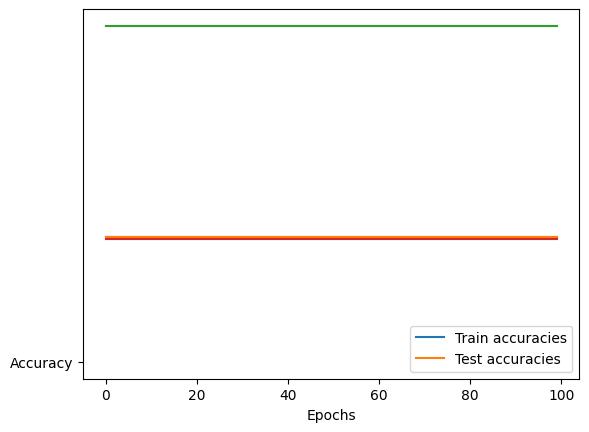

Train accuaracy 0.3333 
 Test accuracy 0.3333


In [42]:
model = FFNetwork(num_hidden = 1)
model.fit(X_train, Y_OH_train, epochs = 100, lr = 0.1)
model.print_accuracy()

  0%|          | 0/100 [00:00<?, ?epoch/s]

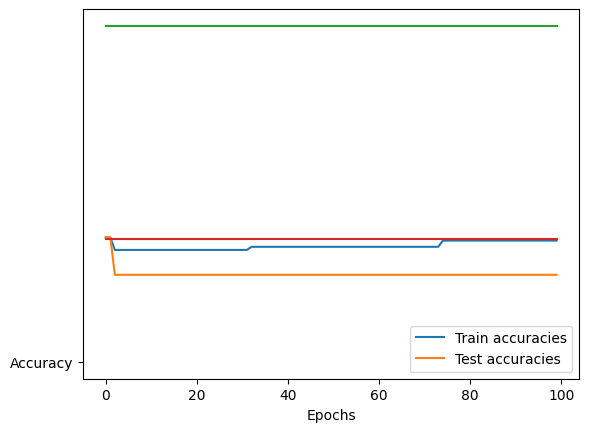

Train accuaracy 0.325 
 Test accuracy 0.2333


In [46]:
model = FFNetwork(num_hidden=2)
model.fit(X_train, Y_OH_train, epochs=100, lr=1, display_loss=False)
model.print_accuracy()

  0%|          | 0/400 [00:00<?, ?epoch/s]

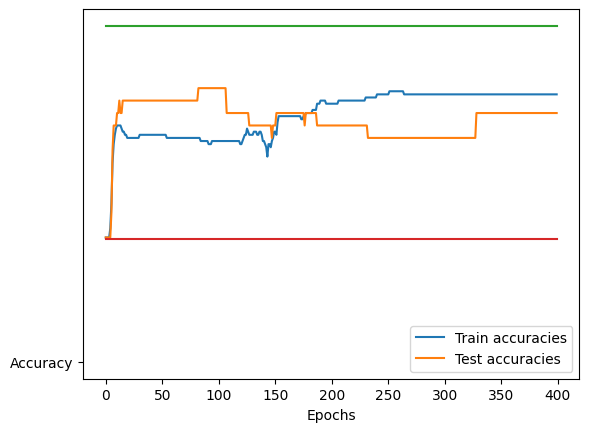

Train accuaracy 0.7167 
 Test accuracy 0.6667


In [47]:
model = FFNetwork(num_hidden=4)
model.fit(X_train, Y_OH_train, epochs=400, lr=0.25, display_loss=False)
model.print_accuracy()

  0%|          | 0/500 [00:00<?, ?epoch/s]

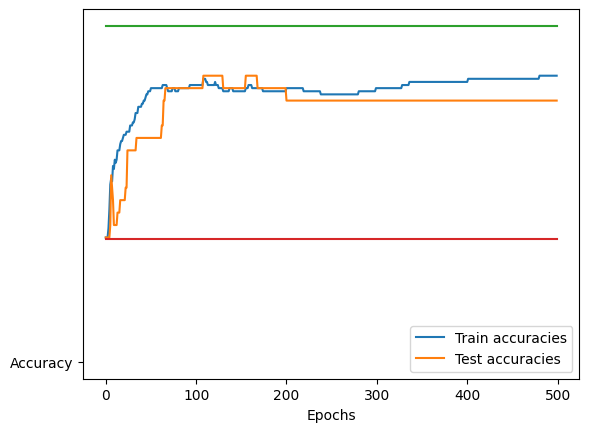

Train accuaracy 0.7667 
 Test accuracy 0.7


In [48]:
model = FFNetwork(num_hidden=8)
model.fit(X_train, Y_OH_train, epochs=500, lr=0.2, display_loss=False)
model.print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

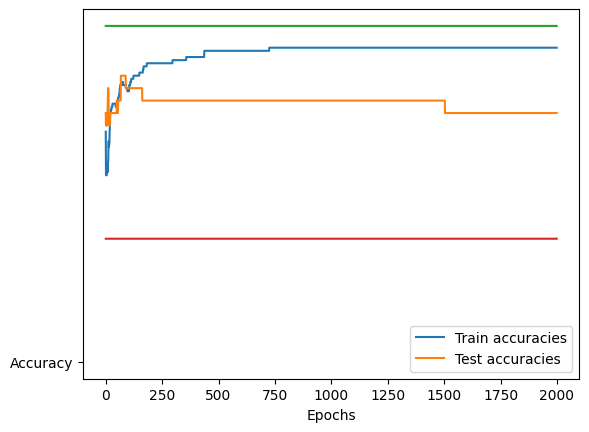

Train accuaracy 0.8417 
 Test accuracy 0.6667


In [51]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, lr=0.1, l2norm=False)
model.print_accuracy()

# **Add L2 Regularisation**

  0%|          | 0/2000 [00:00<?, ?epoch/s]

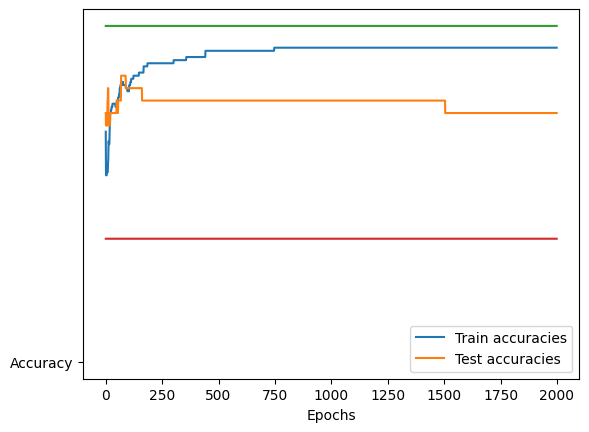

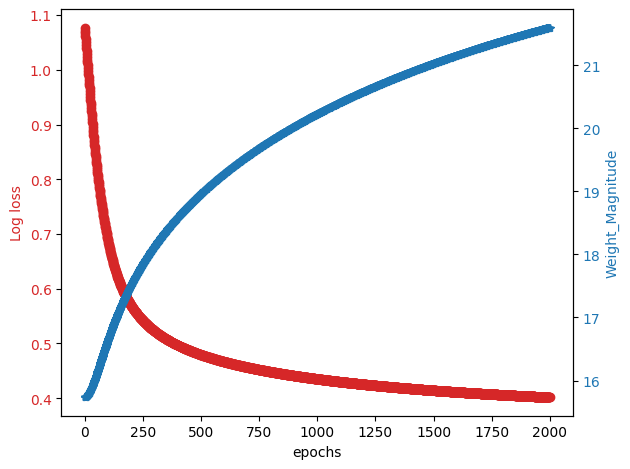

Train accuaracy 0.8417 
 Test accuracy 0.6667


In [63]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, lr=0.1, l2norm=True, lambda_val = 0.1, display_loss = True)
model.print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

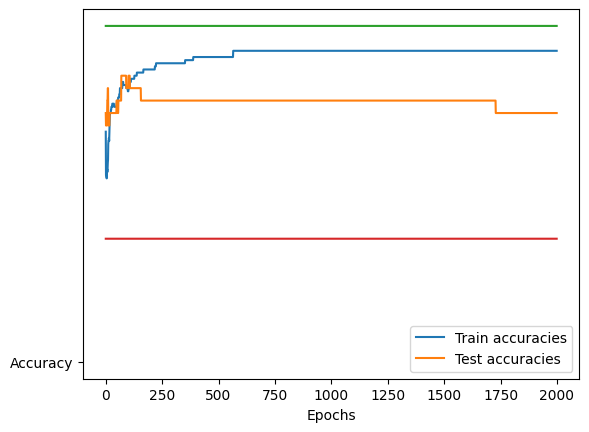

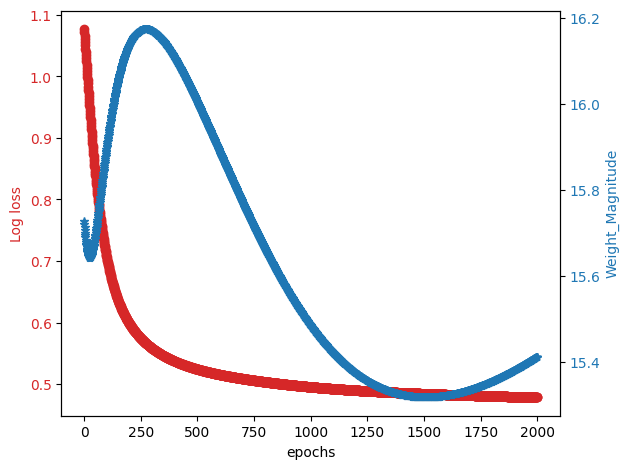

Train accuaracy 0.8333 
 Test accuracy 0.6667


In [65]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, lr=0.1, l2norm=True, lambda_val=1, display_loss=True)
model.print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

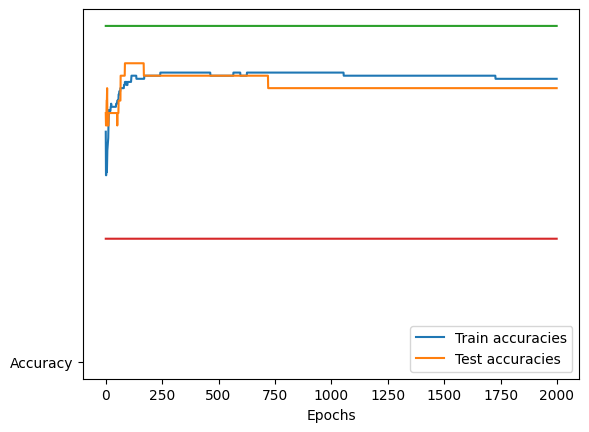

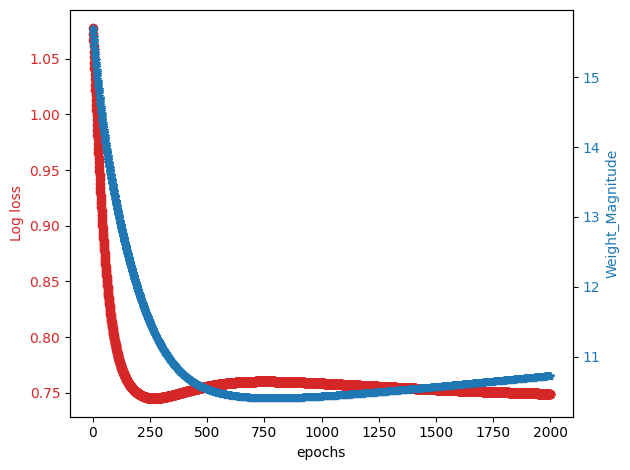

Train accuaracy 0.7583 
 Test accuracy 0.7333


In [66]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, lr=0.1, l2norm=True, lambda_val=5, display_loss=True)
model.print_accuracy()

  0%|          | 0/2000 [00:00<?, ?epoch/s]

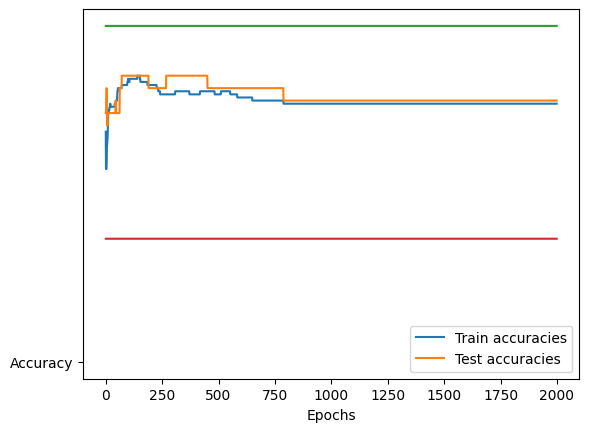

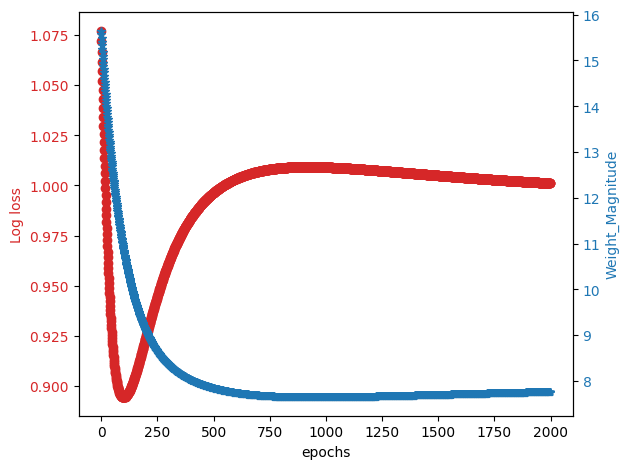

Train accuaracy 0.6917 
 Test accuracy 0.7


In [68]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, lr=0.1, l2norm=True, lambda_val=10, display_loss=True)
model.print_accuracy()

# **Adding Noise to Data**

  0%|          | 0/2000 [00:00<?, ?epoch/s]

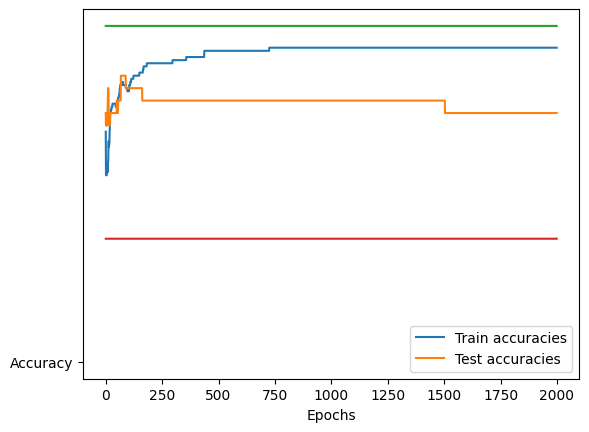

Train accuaracy 0.8417 
 Test accuracy 0.6667


In [69]:
model = FFNetwork(num_hidden=64)
model.fit(X_train, Y_OH_train, epochs=2000, lr=0.1, l2norm=False)
model.print_accuracy()

0.01


  0%|          | 0/2000 [00:00<?, ?epoch/s]

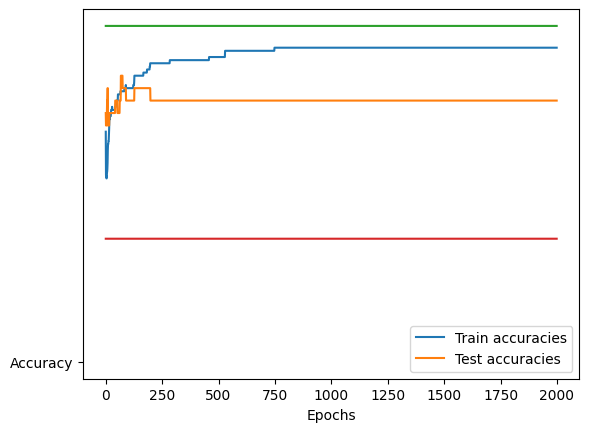

Train accuaracy 0.8417 
 Test accuracy 0.7
0.05


  0%|          | 0/2000 [00:00<?, ?epoch/s]

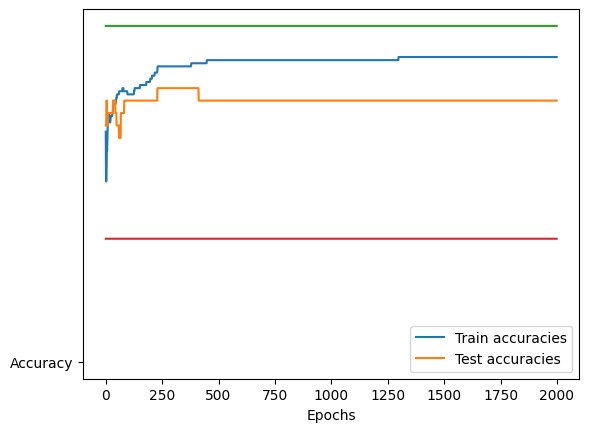

Train accuaracy 0.8167 
 Test accuracy 0.7
0.1


  0%|          | 0/2000 [00:00<?, ?epoch/s]

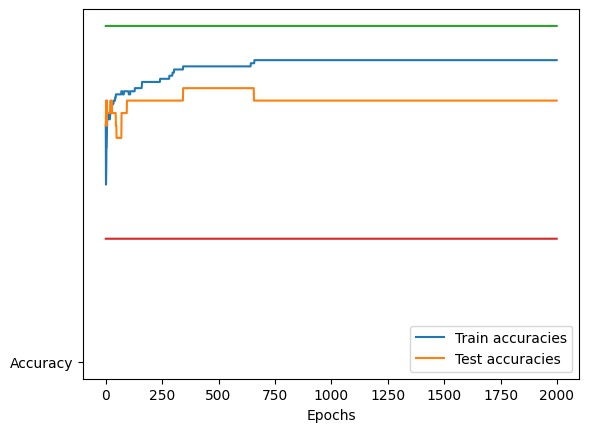

Train accuaracy 0.8083 
 Test accuracy 0.7
0.15


  0%|          | 0/2000 [00:00<?, ?epoch/s]

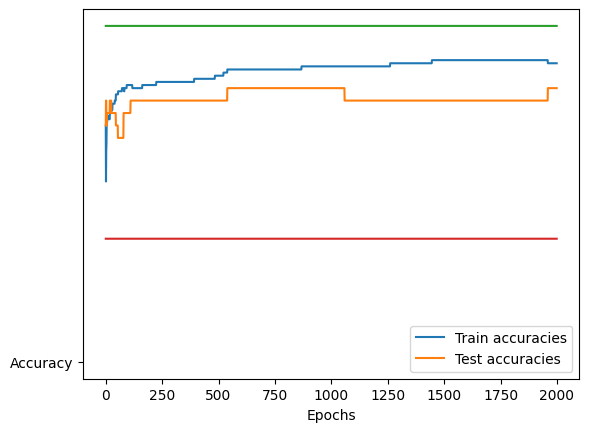

Train accuaracy 0.8 
 Test accuracy 0.7333
0.18


  0%|          | 0/2000 [00:00<?, ?epoch/s]

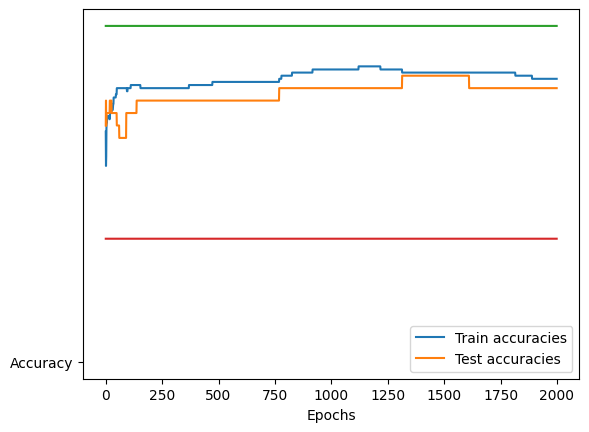

Train accuaracy 0.7583 
 Test accuracy 0.7333
0.2


  0%|          | 0/2000 [00:00<?, ?epoch/s]

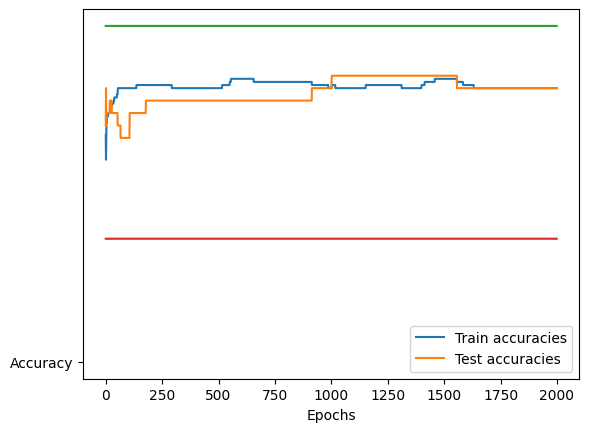

Train accuaracy 0.7333 
 Test accuracy 0.7333


In [70]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  X_train_noisy = X_train * (1 - noise_fraction * np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFNetwork(num_hidden=64)
  model.fit(X_train_noisy, Y_OH_train, epochs=2000, lr=0.1, l2norm=False)
  model.print_accuracy()

# **Early Stopping**

  0%|          | 0/500 [00:00<?, ?epoch/s]

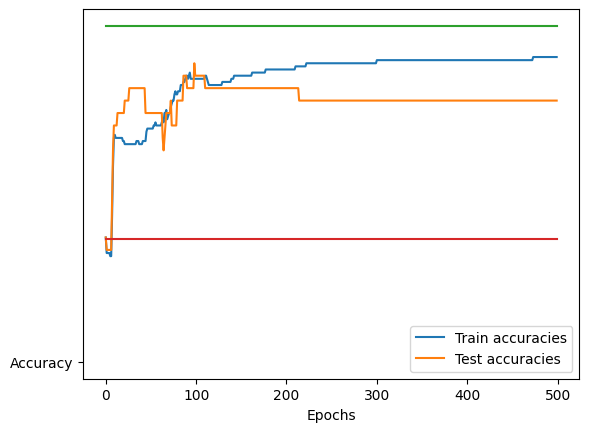

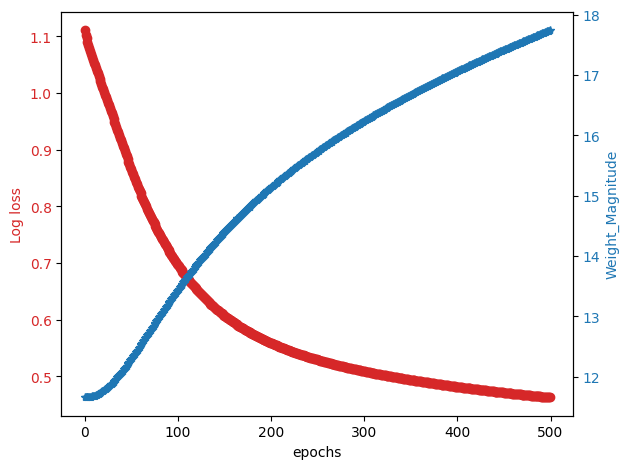

Train accuaracy 0.8167 
 Test accuracy 0.7


In [71]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, Y_OH_train, epochs=500, lr=0.2, display_loss=True)
model.print_accuracy()

  0%|          | 0/100 [00:00<?, ?epoch/s]

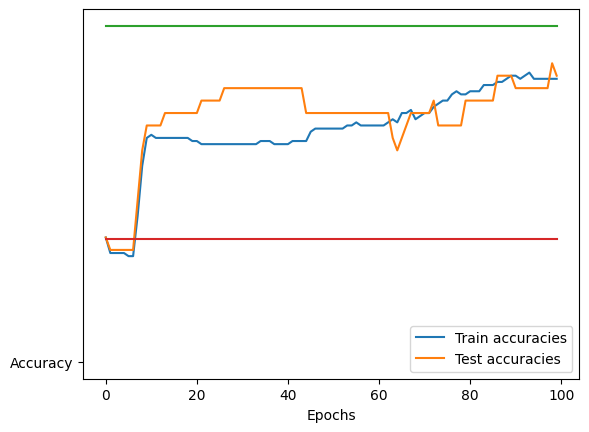

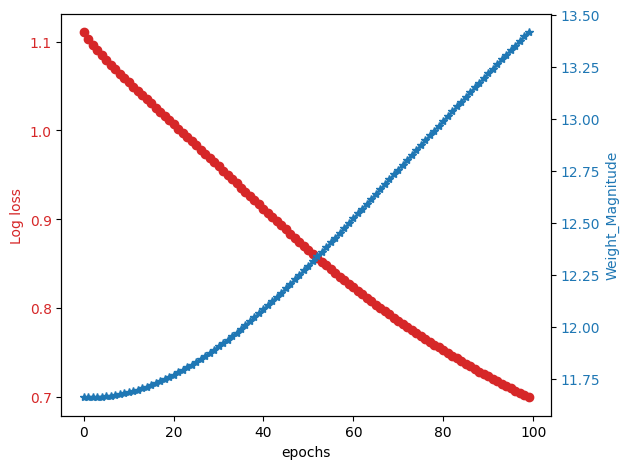

Train accuaracy 0.7583 
 Test accuracy 0.7667


In [72]:
model = FFNetwork(num_hidden=32)
model.fit(X_train, Y_OH_train, epochs=100, lr=0.2, display_loss=True)
model.print_accuracy()